# Data Analysis using __PySpark__  
*Fun with the __MovieLens__ dataset*  

**Part 2: Data Analysis basics using tags.csv from the MovieLens dataset**

<font color='green'>__Support for Google Colab__  </font>

open this notebook in Colab using the following button:  
  
<a href="https://colab.research.google.com/github/shauryashaurya/learn-data-munging/blob/main/03-Spark/002.02-Analyze-MovieLens-using-PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>  

<font color='green'>uncomment and execute the cell below to setup and run this Spark notebook on Google Colab.</font>

In [1]:
# # SETUP FOR COLAB: select all the lines below and uncomment (CTRL+/ on windows)

# # grab spark
# # as of 2023-06-23, the latest version is 3.4.1, get the link from Apache Spark's website
# ! wget -q https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
# # unzip spark
# !tar xf spark-3.4.1-bin-hadoop3.tgz
# # install findspark package
# !pip install -q findspark
# # Let's download and unzip the MovieLens 25M Dataset as well.
# ! mkdir ./../data
# ! wget -q https://files.grouplens.org/datasets/movielens/ml-25m.zip
# ! unzip ./ml-25m.zip -d ./../data/

# # got to provide JAVA_HOME and SPARK_HOME vairables
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# # IMPORTANT - UPDATE THE SPARK_HOME PATH BASED ON THE PACKAGE YOU DOWNLOAD
# os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"
# ! echo "DONE"

## Start the local/colab Spark Cluster

In [2]:
# Step 1: initialize findspark
import findspark

findspark.init()

In [3]:
# Step 2: import pyspark
import pyspark
from pyspark.sql import SparkSession

print(pyspark.__version__)

3.5.0


In [4]:
# Step 3: Create a spark session
#     using local[*] to use as many logical cores as available, use 1 when in doubt
#     'local[1]' indicates spark on 1 core on the local machine or specify the number of cores needed
#     use .config("spark.some.config.option", "some-value") for additional configuration

spark = (
    SparkSession.builder.master("local[*]")
    .appName("Analyzing Movielens Data")
    .getOrCreate()
)

In [1]:
# spark

# Problem Set 1  - ```tags.csv```

1. __Cleanup data__ Some tags may have wrapping quotation marks or similar special characters, also leading/trailing spaces etc.
    * for example, the tag ```"A Christmas Carol"``` becomes ```A Christmas Carol``` etc.
  
1. List all unique tags found in ```tags.csv```  
    * sort all tags lexically 
    * Also print the execution plan  
    * *[think]* If there are multiple ways of doing this, compare the execution plans  
    
1. Which movies have the most number of tags? 
    * List movieIds in order of # of tags associated  
    * Can we find out which movies have most # of *distinct* tags?
    * Does the ```timestamp``` column have any impact on your report?
  
1. Which users have added the most number of tags?
    * List userIds in order of # of tags created  
    * Can we find out which users have created most # of *distinct* tags?
    * Does the ```timestamp``` column have any impact on your report?
  
1. Which users have tagged the most number of movies?
    * Like before, can we find out which users have tagged the most # of *distinct* movies? Does this question make sense in the context of users?
    * Does the ```timestamp``` column have any impact on your report?
  
1. *[optional, skip on first attept]* We want to find out if there were days of higher activity during the tagging exercise or if the tagging output was more-or-less consistent. 
    * Convert time-stamps to Day-Month-Year. 
    * Find the date range (min-date, max-date) during which the tagging activity took place.
    * Plot number of movies tagged per day during the date range

1. *[optional, skip on first attept]* We want to find out how many users were active every day of the tagging activity. 
    * Plot number of users who tagged at least one movie during the tagging activity date range

# Load Tags data from the MovieLens dataset

In [6]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [7]:
#
datalocation = "../data/ml-25m/"
file_path_tags = datalocation + "tags.csv"
#
schema_tags = StructType(
    [
        StructField("userId", StringType(), False),
        StructField("movieId", StringType(), False),
        StructField("tag", StringType(), True),
        StructField("timestamp", StringType(), True),
    ]
)
#
tags_raw = (
    spark.read.format("csv")
    .option("encoding", "UTF-8")
    .option("header", True)
    .option("sep", ",")
    .option("escape", '"')
    .schema(schema_tags)
    .load(file_path_tags)
)

In [8]:
tags_raw.show(10, False)

+------+-------+-----------------------+----------+
|userId|movieId|tag                    |timestamp |
+------+-------+-----------------------+----------+
|3     |260    |classic                |1439472355|
|3     |260    |sci-fi                 |1439472256|
|4     |1732   |dark comedy            |1573943598|
|4     |1732   |great dialogue         |1573943604|
|4     |7569   |so bad it's good       |1573943455|
|4     |44665  |unreliable narrators   |1573943619|
|4     |115569 |tense                  |1573943077|
|4     |115713 |artificial intelligence|1573942979|
|4     |115713 |philosophical          |1573943033|
|4     |115713 |tense                  |1573943042|
+------+-------+-----------------------+----------+
only showing top 10 rows



# Solutions to Problem Set 1

### Cleanup  
Some tags may have wrapping quotation marks or similar special characters, also leading/trailing spaces etc. Cleanup tags  

* for example, the tag "A Christmas Carol" becomes A Christmas Carol etc.

In [9]:
# Remove wrapping quotation marks from tags

# if there's cleanup needed,
# we do that first before finding out unique records,
# chances are uniqueness will be affected if we don't follow this order.

# code clean up update - importing * from pyspark.sql.functions at the top of the notebook
# from pyspark.sql.functions import col, lower, regexp_replace, trim

In [10]:
# define a regex pattern to use.
# ^ indicates start of string, $ indicates end of string
# double quote or single quote or ampersand or bang just after start of string
pattern_start = "^\"|^'|^&|^#"
# double quote or single quote or ampersand or bang just before end of string
pattern_end = "\"$|'$|&$|#$"
pattern = pattern_start + "|" + pattern_end

In [11]:
# create a new tags dataframe with cleaned up data
tags = tags_raw.withColumn("tag", regexp_replace(trim(col("tag")), pattern, ""))

In [12]:
# quotes stripped and other chars too...
tags_raw.filter(col("tag").contains("Christmas Carol")).show()
tags.filter(col("tag").contains("Christmas Carol")).show()

+------+-------+-------------------+----------+
|userId|movieId|                tag| timestamp|
+------+-------+-------------------+----------+
| 63844|   4023|"A Christmas Carol"|1457037403|
+------+-------+-------------------+----------+

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
| 63844|   4023|A Christmas Carol|1457037403|
+------+-------+-----------------+----------+



### List all unique tags found in ```tags.csv```  
    * sort all tags lexically 
    * Also print the execution plan  
    * *[think]* If there are multiple ways of doing this, compare the execution plans  

In [13]:
# unique tags found in tags.csv - prep
# careful - comparision should be case-insensitive
# because 'Christmas Special' and 'Christmas special' are really the same thing
# create a new column in tags
tags = tags.withColumn("lower tag", lower(col("tag")))
# reorder columns for easy readability
tags = tags.select("userId", "movieId", "tag", "lower tag", "timestamp")
tags.show(5, False)

+------+-------+----------------+----------------+----------+
|userId|movieId|tag             |lower tag       |timestamp |
+------+-------+----------------+----------------+----------+
|3     |260    |classic         |classic         |1439472355|
|3     |260    |sci-fi          |sci-fi          |1439472256|
|4     |1732   |dark comedy     |dark comedy     |1573943598|
|4     |1732   |great dialogue  |great dialogue  |1573943604|
|4     |7569   |so bad it's good|so bad it's good|1573943455|
+------+-------+----------------+----------------+----------+
only showing top 5 rows



In [14]:
# unique tags found in tags.csv - method 1, using distinct()
distinct_tags1 = tags.select("lower tag").distinct()
#
# let's do the explaining later, so it's easy to compare methods
# distinct_tags.explain(True)
# show 5 rows, do not truncate
distinct_tags1.show(5, False)

+-------------+
|lower tag    |
+-------------+
|anime        |
|art          |
|traveling    |
|travel       |
|loss of child|
+-------------+
only showing top 5 rows



In [15]:
# unique tags found in tags.csv - method 2, using groupBy()
# an aggregator like count() results in a dataframe
# distinct_tags2 = tags.select('lower tag').groupBy('lower tag').count()
distinct_tags2 = tags.select("lower tag").groupBy("lower tag").count()
# let's do the explaining later, so it's easy to compare methods
# distinct_tags2.explain(True)
# show 5 rows, no truncate
distinct_tags2.show(5, False)

+-------------+-----+
|lower tag    |count|
+-------------+-----+
|anime        |1585 |
|art          |340  |
|traveling    |14   |
|travel       |256  |
|loss of child|21   |
+-------------+-----+
only showing top 5 rows



Compare execution plan explanations for distinct() and groupBy()...  
(uncomment the lines below)
also [reference documentation](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.explain.html#pyspark.sql.DataFrame.explain)

In [16]:
# extended set as True
# to see something specific choose a mode
# distinct_tags1.explain(True)

In [17]:
# distinct_tags2.explain(True)

Compare the costs in the two execution plans

In [18]:
distinct_tags1.explain(mode="cost")

== Optimized Logical Plan ==
Aggregate [lower tag#77], [lower tag#77], Statistics(sizeInBytes=11.8 MiB)
+- Project [lower(regexp_replace(trim(tag#2, None), ^"|^'|^&|^#|"$|'$|&$|#$, , 1)) AS lower tag#77], Statistics(sizeInBytes=11.8 MiB)
   +- Relation [userId#0,movieId#1,tag#2,timestamp#3] csv, Statistics(sizeInBytes=37.0 MiB)

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lower tag#77], functions=[], output=[lower tag#77])
   +- Exchange hashpartitioning(lower tag#77, 200), ENSURE_REQUIREMENTS, [plan_id=176]
      +- HashAggregate(keys=[lower tag#77], functions=[], output=[lower tag#77])
         +- Project [lower(regexp_replace(trim(tag#2, None), ^"|^'|^&|^#|"$|'$|&$|#$, , 1)) AS lower tag#77]
            +- FileScan csv [tag#2] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/C:/shaurya/lab/learn-data-munging/data/ml-25m/tags.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<tag:string>




In [19]:
# distinct_tags2.explain(mode='cost')

The two plans look identical:

**distinct()**  
  
```
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [lower tag#130 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(lower tag#130 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#1415]
      +- HashAggregate(keys=[lower tag#130], functions=[], output=[lower tag#130])
         +- Exchange hashpartitioning(lower tag#130, 200), ENSURE_REQUIREMENTS, [id=#1412]
            +- HashAggregate(keys=[lower tag#130], functions=[], output=[lower tag#130])
               +- Project [lower(regexp_replace(trim(tag#55, None), ^"|^'|^&|^#|"$|'$|&$|#$, , 1)) AS lower tag#130]
                  +- FileScan csv [tag#55] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/.../tags.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<tag:string>
```

**groupBy()**  
  
```
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [lower tag#130 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(lower tag#130 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#1437]
      +- HashAggregate(keys=[lower tag#130], functions=[count(1)], output=[lower tag#130, count#176L])
         +- Exchange hashpartitioning(lower tag#130, 200), ENSURE_REQUIREMENTS, [id=#1434]
            +- HashAggregate(keys=[lower tag#130], functions=[partial_count(1)], output=[lower tag#130, count#186L])
               +- Project [lower(regexp_replace(trim(tag#55, None), ^"|^'|^&|^#|"$|'$|&$|#$, , 1)) AS lower tag#130]
                  +- FileScan csv [tag#55] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/.../tags.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<tag:string>
```


Spark optimizes both to identical plans / Inner workings for both seem identical in the optimized execution plan.  

So we tend to prefer the one that is easier to read when debugging the code.  

There may be a need for both distinct() and groupBy() in the same piece of code - for readability. We'll see that a few sections later.  

*In some cases, I saw (and I am probably wrong here) that the groupBy() method seems marginally more expensive in terms of memory as compared to distinct(). Log a comment/ticket/PR if you have evidence, insights, ideas to the contrary/in-support.*

#### Sort lexically

In [20]:
# sort unique tags lexically
# ignore case when sorting values
distinct_tags1 = distinct_tags1.orderBy(col("lower tag").asc())
distinct_tags2 = distinct_tags2.orderBy(col("lower tag").asc())

In [21]:
distinct_tags1.filter(col("lower tag").contains("christmas")).show(50, False)

+-----------------------------------------------------------+
|lower tag                                                  |
+-----------------------------------------------------------+
|a christmas carol                                          |
|anti christmas                                             |
|best christmas movie                                       |
|christmas                                                  |
|christmas bonus                                            |
|christmas card                                             |
|christmas carol                                            |
|christmas england history                                  |
|christmas eve                                              |
|christmas gift                                             |
|christmas holiday                                          |
|christmas horror                                           |
|christmas lights                                           |
|christm

In [22]:
distinct_tags2.filter(col("lower tag").contains("christmas")).show(50, False)

+-----------------------------------------------------------+-----+
|lower tag                                                  |count|
+-----------------------------------------------------------+-----+
|a christmas carol                                          |1    |
|anti christmas                                             |1    |
|best christmas movie                                       |7    |
|christmas                                                  |1162 |
|christmas bonus                                            |1    |
|christmas card                                             |2    |
|christmas carol                                            |11   |
|christmas england history                                  |1    |
|christmas eve                                              |36   |
|christmas gift                                             |5    |
|christmas holiday                                          |4    |
|christmas horror                               

### Which movies have the most number of tags?  
* List movieIds in order of # of tags associated  
* Can we find out which movies have most # of *distinct* tags?  
* *[optional]* Does the ```timestamp``` column have any impact on your report?  

In [22]:
# movie IDs with most number of tags
movies_by_tag_count = tags.groupBy("movieId").count()
movies_by_tag_count.orderBy(col("count").desc()).show()

+-------+-----+
|movieId|count|
+-------+-----+
|    260| 6180|
|    296| 4767|
|  79132| 4767|
| 109487| 3616|
|   2959| 3612|
|    318| 3597|
|   2571| 3573|
|    356| 2701|
|   4226| 2601|
|   7361| 2533|
|    593| 2482|
|   4878| 2417|
|   4973| 2226|
|  48780| 2126|
| 115713| 2115|
|  72998| 2105|
|    541| 2081|
|  58559| 1956|
|     47| 1947|
|   2858| 1904|
+-------+-----+
only showing top 20 rows



These movies have thousands of tags??? that makes no sense... let's see what some of those are:

In [23]:
tags.filter(col("movieId") == 260).groupBy(
    lower(col("tag")).alias("lowercase tag")
).count().orderBy(col("count").desc()).show(25, False)

+---------------+-----+
|lowercase tag  |count|
+---------------+-----+
|sci-fi         |658  |
|space          |302  |
|classic        |273  |
|science fiction|270  |
|space adventure|263  |
|classic sci-fi |232  |
|action         |178  |
|adventure      |160  |
|fantasy        |150  |
|star wars      |143  |
|space opera    |139  |
|harrison ford  |117  |
|good vs evil   |115  |
|epic           |112  |
|space action   |104  |
|space epic     |84   |
|cult classic   |76   |
|george lucas   |71   |
|epic adventure |55   |
|jedi           |55   |
|scifi          |54   |
|aliens         |53   |
|futuristic     |51   |
|scifi cult     |46   |
|hero's journey |45   |
+---------------+-----+
only showing top 25 rows



Any guesses what this movie could be?
Let's quickly load the movies data:

In [24]:
file_path_movies = datalocation + "movies.csv"
#
schema_movies = StructType(
    [
        StructField("movieId", StringType(), False),
        StructField("title", StringType(), False),
        StructField("genres", StringType(), True),
    ]
)
#
movies_raw = (
    spark.read.format("csv")
    .option("encoding", "UTF-8")
    .option("header", True)
    .option("sep", ",")
    .option("escape", '"')
    .schema(schema_movies)
    .load(file_path_movies)
)

In [25]:
movies_raw.filter(col("movieId") == 260).show(1, False)

+-------+-----------------------------------------+-----------------------+
|movieId|title                                    |genres                 |
+-------+-----------------------------------------+-----------------------+
|260    |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|
+-------+-----------------------------------------+-----------------------+



No surprises there!

### Which users have added the most number of tags?

* List ```userIds``` in order of # of tags created
* Can we find out which users have created most # of distinct tags?

In [26]:
# users who have created most tags
users_by_count_of_tag_entries = tags.groupBy("userId").count()
users_by_count_of_tag_entries.orderBy(col("count").desc()).show()

+------+------+
|userId| count|
+------+------+
|  6550|183356|
| 21096| 20317|
| 62199| 13700|
|160540| 12076|
|155146| 11445|
| 70092| 10582|
|131347| 10195|
| 14116| 10167|
| 31047|  8463|
|141263|  7114|
| 64333|  6944|
| 47969|  6599|
| 15204|  6426|
| 84824|  6209|
|123527|  6005|
|148457|  5960|
| 19346|  5919|
|  6285|  5837|
| 96795|  5334|
| 44444|  4941|
+------+------+
only showing top 20 rows



Can we find out which users have created most # of distinct tags?

In [27]:
# isolate userId and tags and identify distinct pairs
distinct_tags_by_user = tags.select("userId", "tag").distinct()
# count distinct tags by user
count_distinct_tags_by_user = distinct_tags_by_user.groupBy("userId").count()
# list count of distinct tags by user
count_distinct_tags_by_user.orderBy(col("count").desc()).show()

+------+-----+
|userId|count|
+------+-----+
|  6550|20765|
| 31047| 5574|
|155146| 5252|
| 62199| 4959|
|131347| 4834|
|160540| 4783|
|148457| 3550|
| 47969| 3042|
| 14116| 2913|
|141263| 2837|
| 19346| 2808|
| 96795| 2304|
| 64333| 2268|
| 15204| 2190|
| 44444| 2156|
|105728| 2150|
|123527| 2131|
| 34047| 2103|
| 56238| 2018|
| 83426| 1942|
+------+-----+
only showing top 20 rows



*Holy Sith!* 

*183356* tags, *20765* unique tags - UserId ```6550``` is either a beast or probably a bot!  

In most cases we may want to treat this one as an outlier, further analysis may be needed before taking that decision, but it's good to know 6550 exists.  

In [28]:
distinct_tags_by_user.filter(col("userId") == "6550").orderBy(col("tag")).show(
    50, False
)

+------+---------------+
|userId|tag            |
+------+---------------+
|6550  |007            |
|6550  |077            |
|6550  |10th century   |
|6550  |11th century   |
|6550  |12th century   |
|6550  |13th century   |
|6550  |14th century   |
|6550  |15th century   |
|6550  |16th century   |
|6550  |17th century   |
|6550  |1860s          |
|6550  |18th century   |
|6550  |1910s          |
|6550  |1920s          |
|6550  |1930s          |
|6550  |1940s          |
|6550  |1950s          |
|6550  |1960s          |
|6550  |1970s          |
|6550  |1980s          |
|6550  |1990s          |
|6550  |19th century   |
|6550  |1st century    |
|6550  |2040s          |
|6550  |20th century   |
|6550  |21st century   |
|6550  |25th century   |
|6550  |2nd century    |
|6550  |3 dimensional  |
|6550  |360 video      |
|6550  |3d             |
|6550  |47 ronin       |
|6550  |80's           |
|6550  |80's style     |
|6550  |Afghanistan    |
|6550  |Africa         |
|6550  |Agent Coulson  |


Yeah! I'd say 6550 is some automated tagging mechanism. 

### Which users have tagged the most number of movies?
* Like before, can we find out which users have tagged the most # of *distinct* movies? Does this question make sense in the context of users?
* *[optional]* Does the ```timestamp``` column have any impact on your report?

In [29]:
# which users have tagged the most number of movies?

# approach:
# create a df that has only users and movies
# this df may have multiple rows for
# same userId and movieId as each user has given many tags to each movie
# so only pick distinct records.
# then use groupBy and count as ususal

users_and_movies_in_tags = tags.select("userId", "movieId").distinct()

users_and_movies_in_tags_count = (
    users_and_movies_in_tags.groupBy("userId").count().orderBy(col("count").desc())
)

users_and_movies_in_tags_count.show(10)

+------+-----+
|userId|count|
+------+-----+
|  6550|37913|
| 62199|10840|
| 21096| 7547|
| 70092| 7171|
| 64333| 2615|
| 14116| 2361|
| 72360| 2073|
|125054| 1712|
|131347| 1602|
| 34164| 1526|
+------+-----+
only showing top 10 rows



In [30]:
# check:
# filter for any one userId, check that all movies occur only once
users_and_movies_in_tags.filter(col("userId") == 6550).groupBy(
    "movieId"
).count().orderBy(col("count").desc()).show(10)

+-------+-----+
|movieId|count|
+-------+-----+
|   2069|    1|
|   3959|    1|
|  26112|    1|
|  60336|    1|
|   1436|    1|
|   3210|    1|
|   2904|    1|
|  35640|    1|
|   7252|    1|
|   2136|    1|
+-------+-----+
only showing top 10 rows



### Tagging activity related analysis

* Convert time-stamps to Day-Month-Year.
* Find the date range (min-date, max-date) during which the tagging activity took place.
* Plot number of movies tagged per day during the date range

In [31]:
# code cleanup update - all sql.functions imported at the top of this notebook
# from pyspark.sql.functions import from_unixtime, to_date

# convert unix epoch timestamp to date-time style timestamp
tags = tags.withColumn("datetime", from_unixtime(col("timestamp")))
# extract date from date-time timestamp
tags = tags.withColumn("tagging date", to_date(col("datetime")))
tags.show(10, False)

+------+-------+-----------------------+-----------------------+----------+-------------------+------------+
|userId|movieId|tag                    |lower tag              |timestamp |datetime           |tagging date|
+------+-------+-----------------------+-----------------------+----------+-------------------+------------+
|3     |260    |classic                |classic                |1439472355|2015-08-13 18:55:55|2015-08-13  |
|3     |260    |sci-fi                 |sci-fi                 |1439472256|2015-08-13 18:54:16|2015-08-13  |
|4     |1732   |dark comedy            |dark comedy            |1573943598|2019-11-17 04:03:18|2019-11-17  |
|4     |1732   |great dialogue         |great dialogue         |1573943604|2019-11-17 04:03:24|2019-11-17  |
|4     |7569   |so bad it's good       |so bad it's good       |1573943455|2019-11-17 04:00:55|2019-11-17  |
|4     |44665  |unreliable narrators   |unreliable narrators   |1573943619|2019-11-17 04:03:39|2019-11-17  |
|4     |115569 |ten

In [32]:
tagging_activity_by_date = tags.groupBy(col("tagging date")).count()
#
tagging_activity_by_date.orderBy(col("count").desc()).show(5, False)

+------------+-----+
|tagging date|count|
+------------+-----+
|2018-06-10  |26871|
|2018-05-27  |26644|
|2018-05-28  |21775|
|2018-05-18  |20808|
|2018-05-25  |18488|
+------------+-----+
only showing top 5 rows



#### date range during which the tagging activity took place

* (min-date, max-date) 

In [33]:
# code cleanup update - all sql.functions imported at the top of this notebook
# from pyspark.sql.functions import avg, max, min

#
tagging_min_date = tagging_activity_by_date.select(min(col("tagging date")))
tagging_max_date = tagging_activity_by_date.select(max(col("tagging date")))
#
tagging_min_date.show()
tagging_max_date.show()
# tagging_activity_by_date.select(min(col('count'))).show()
# tagging_activity_by_date.select(max(col('count'))).show()
# tagging_activity_by_date.select(avg(col('count'))).show()
tagging_activity_by_date.summary().show()

+-----------------+
|min(tagging date)|
+-----------------+
|       2005-12-24|
+-----------------+

+-----------------+
|max(tagging date)|
+-----------------+
|       2019-11-21|
+-----------------+

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|             5056|
|   mean|           216.25|
| stddev|848.8262672935349|
|    min|                1|
|    25%|               61|
|    50%|              120|
|    75%|              224|
|    max|            26871|
+-------+-----------------+



In [34]:
# setup matplotlib before starting plotting
import matplotlib.pyplot as plt

# jupyter mpl magic
%matplotlib inline

# note: in case you want to use the widget or notebook magic:
# ensure that ipympl is also installed.
# there may be other steps involved as well
# for e.g. widget works based on nodeJS, so you'll have to config/enable that too

In [35]:
# determine the X and Y lists for plotting.
# converting a spark dataframe column to list:
tagging_activity_x = (
    tagging_activity_by_date.select(col("tagging date"))
    .rdd.flatMap(lambda x: x)
    .collect()
)

tagging_activity_y = (
    tagging_activity_by_date.select(col("count")).rdd.flatMap(lambda x: x).collect()
)

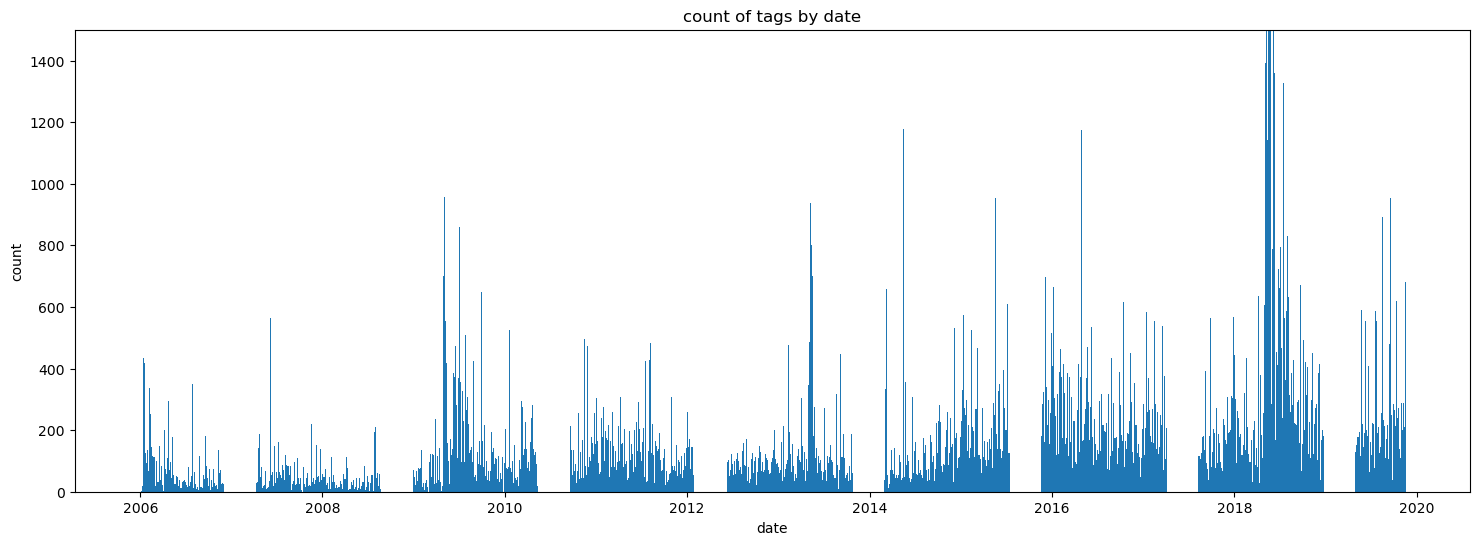

In [36]:
plt.figure(figsize=(18, 6))
plt.bar(tagging_activity_x, tagging_activity_y)
# Don't need to skew the graph with some really high counts
# limit to 1500
ax = plt.gca()
ax.set_ylim([0, 1500])
plt.title("count of tags by date")
plt.xlabel("date")
plt.ylabel("count")
plt.show()

Seems like the activity peaked extraordinarily around May/June 2018

### Daily active users during the tagging activity.

* Plot number of users who tagged at least one movie during the tagging activity date range

In [37]:
distinct_users_doing_tagging_by_date = (
    tags.select("userId", "tagging date").distinct().groupBy("tagging date").count()
)
#
distinct_users_doing_tagging_by_date.orderBy(col("count").desc()).show(5)
distinct_users_doing_tagging_by_date.summary().show()

+------------+-----+
|tagging date|count|
+------------+-----+
|  2015-08-17|  180|
|  2018-05-06|   87|
|  2018-05-05|   78|
|  2018-05-07|   71|
|  2015-07-27|   64|
+------------+-----+
only showing top 5 rows

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|             5056|
|   mean|16.48378164556962|
| stddev|9.770346849818784|
|    min|                1|
|    25%|               10|
|    50%|               15|
|    75%|               21|
|    max|              180|
+-------+-----------------+



In [38]:
# like before, we need to determine X and Y lists.

distinct_users_doing_tagging_by_date_x = (
    distinct_users_doing_tagging_by_date.select(col("tagging date"))
    .rdd.flatMap(lambda x: x)
    .collect()
)

distinct_users_doing_tagging_by_date_y = (
    distinct_users_doing_tagging_by_date.select(col("count"))
    .rdd.flatMap(lambda x: x)
    .collect()
)

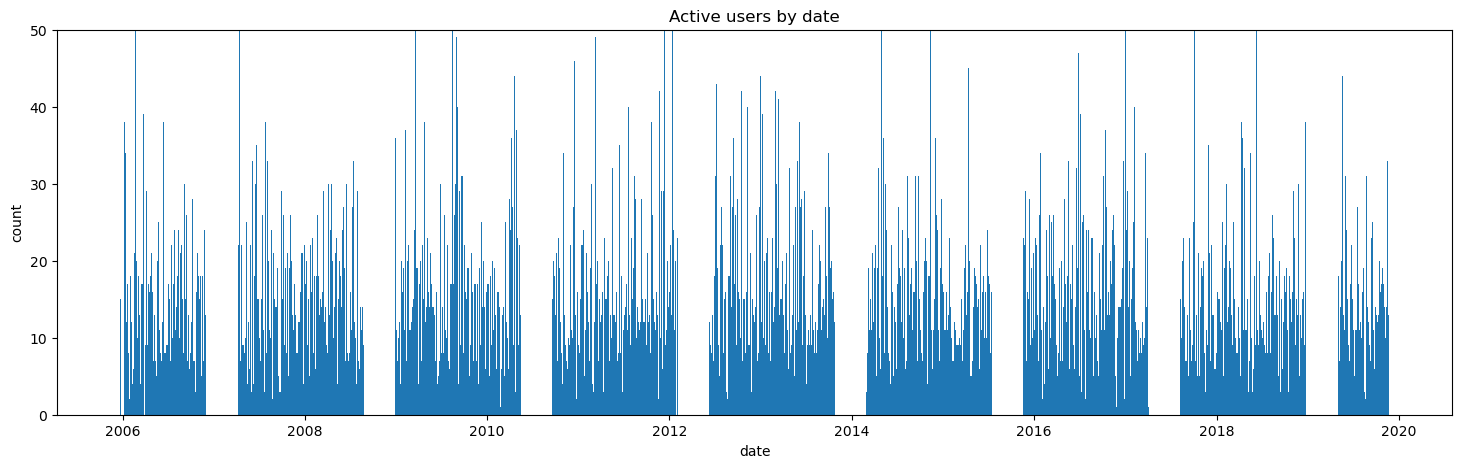

In [39]:
plt.figure(figsize=(18, 5))
plt.bar(distinct_users_doing_tagging_by_date_x, distinct_users_doing_tagging_by_date_y)
# limit the y axis, some observations may go beyond the ceiling
ax = plt.gca()
ax.set_ylim([0, 50])
plt.title("Active users by date")
plt.xlabel("date")
plt.ylabel("count")
plt.show()

Seems like while there were peaks and troughs, but visually, we don't see too much variation in the daily active users

# Clear cache and stop the spark cluster

In [40]:
# clear cache
spark.catalog.clearCache()

In [41]:
# stop spark
spark.stop()

# Insights

What have we learned from working on Problem Set 1?

1. Try to get a specific schema
1. Clean up data before analysis or aggregation
1. Clearly document weather you need case sensitive or case insensitive comparisions
1. Use ```df.withColumn``` to create new columns
1. ```col().contains()``` is like the ```LIKE``` clause in SQL, partial matches etc.
1. Spark Columns: Only use literal name where it's trivial, otherwise prefer ```col('name')```
1. ```distinct()``` vs ```groupBy()```
1. To convert a column in a spark data frame to a list (for plotting data or other uses) you isolate the column, convert to rdd, flatmap, collect.
  
1. and another thing... use ```spark.catalog.clearCache()``` to clear the cache

# Next

We continue our data analysis exercises with the movies.csv data.